Постановка задачи
Необходимо построить модель, которая предсказывает к какому из трех сегментов (0,1,2) относится каждый абонент.

Обучающая выборка contest_train.csv состоит из следующих столбцов:

ID - идентификатор абонента.
TARGET - соответствующий абоненту сегмент.
FEATURE_0…FEATURE_259 — характеристики абонента.
Тестовая выборка contest_test.csv состоит из столбца ID и следующими за ним столбцами FEATURE_0 … FEATURE_259

Точность предсказания оценивается по метрике macro-f1_score.
Распределение Public/Private - 50%/50%

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 300)

from IPython.core.display import display, HTML # расширяем блокнот
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns', None) # выводим все колонки

from IPython.core.interactiveshell import InteractiveShell # выводим все результаты из ячейки
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv('contest_train.csv')
dft = pd.read_csv('contest_test.csv')

In [3]:
df = df.fillna(df.mean())
dft = dft.fillna(dft.mean())

In [4]:
df.head()

,ID,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,0d1c880d23ff018,1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-114.527812,...,39.0,2.0,223.118594,290.015143,1.0,1.0,0.0,1.0,2.0,2.0
1,1579ba37fd82c1f,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,329.828334,...,25.0,82.0,479.616045,611.651594,0.0,1.0,0.0,1.0,1.0,1.0
2,790086f721c7f5e,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,...,119.0,0.0,352.268014,564.573421,1.0,1.0,0.0,1.0,1.0,1.0
3,b0a2078cf33c226,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.621397,...,1.0,0.0,410.524985,421.653876,1.0,0.0,0.0,1.0,2.0,2.0
4,d0c46717b9cb323,0,4.0,3.0,1.0,0.0,1.0,0.0,0.0,677.745861,...,21.0,0.0,439.171356,476.189288,1.0,1.0,0.0,1.0,1.0,1.0


In [5]:
print(len(df), len(dft))

24521 9484


In [7]:
df.dtypes

ID              object
TARGET           int64
FEATURE_0      float64
FEATURE_1      float64
FEATURE_2      float64
                ...   
FEATURE_255    float64
FEATURE_256    float64
FEATURE_257    float64
FEATURE_258    float64
FEATURE_259    float64
Length: 262, dtype: object

In [6]:
df.describe()

,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
count,24521.000000,24521.000000,24521.000000,24521.000000,24521.0,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,...,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.0,24521.000000,24521.00000,24521.000000
mean,0.352677,5.438196,1.337833,0.056401,0.0,0.141226,0.000163,0.011378,80.762084,278.787390,...,41.057379,36.403205,307.827071,408.052350,0.611965,0.640390,0.0,1.138575,1.18580,1.184699
std,0.592092,14.533334,1.826413,0.230698,0.0,0.348262,0.012771,0.106061,256.605853,1177.974402,...,105.000146,105.872566,259.669681,349.968987,0.487312,0.479896,0.0,0.373638,0.40809,0.401288
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-171.709797,-297.065679,...,-1256.000000,-667.000000,-1531.063435,-328.361649,0.000000,0.000000,0.0,1.000000,0.00000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-9.809139,-19.140528,...,0.000000,0.000000,129.829124,179.694989,0.000000,0.000000,0.0,1.000000,1.00000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.673798,6.508163,...,6.000000,0.000000,265.472906,326.928038,1.000000,1.000000,0.0,1.000000,1.00000,1.000000
75%,1.000000,5.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,27.367809,47.143287,...,39.000000,10.000000,408.197249,533.731611,1.000000,1.000000,0.0,1.000000,1.00000,1.000000
max,2.000000,385.000000,39.000000,1.000000,0.0,1.000000,1.000000,1.000000,3147.341440,9963.242114,...,1775.000000,3194.000000,4202.905396,4440.534979,1.000000,1.000000,0.0,3.000000,3.00000,3.000000


In [7]:
df.nunique()

ID             24521
TARGET             3
FEATURE_0        160
FEATURE_1         22
FEATURE_2          2
               ...  
FEATURE_255        2
FEATURE_256        1
FEATURE_257        3
FEATURE_258        4
FEATURE_259        3
Length: 262, dtype: int64

In [8]:
feature_names = df.columns.tolist() 
for column in feature_names: 
    print (column )
    print (df[column].value_counts(dropna=False) )

ID
d28c7dd63d0fccb    1
a69b5ecbd5f17ab    1
9def4278aa0a5aa    1
1672026eb74cade    1
a54b808cb4bde09    1
                  ..
a9710b2c4d64d57    1
02c73167cd4b96e    1
556e1376dbe8f6f    1
22e85302735809a    1
a9495b9f1063db0    1
Name: ID, Length: 24521, dtype: int64
TARGET
0    17372
1     5650
2     1499
Name: TARGET, dtype: int64
FEATURE_0
0.0      10612
1.0       3158
2.0       2023
3.0       1397
4.0       1101
         ...  
148.0        1
145.0        1
134.0        1
270.0        1
156.0        1
Name: FEATURE_0, Length: 160, dtype: int64
FEATURE_1
0.0     10612
1.0      5923
2.0      3451
3.0      1903
4.0      1103
5.0       648
6.0       376
7.0       202
8.0       116
9.0        76
10.0       50
12.0       19
11.0       16
13.0       10
14.0        7
17.0        2
19.0        2
30.0        1
15.0        1
39.0        1
18.0        1
31.0        1
Name: FEATURE_1, dtype: int64
FEATURE_2
0.0    23138
1.0     1383
Name: FEATURE_2, dtype: int64
FEATURE_3
0.0    24521
Name: 

 1190.241883     1
 3.005285        1
-5.363523        1
 1779.572344     1
 3140.589716     1
                ..
-15.018485       1
-2.218381        1
 0.081189        1
 11728.183667    1
-58.329023       1
Name: FEATURE_47, Length: 24521, dtype: int64
FEATURE_48
 2129.237092    1
-11.071542      1
 13.649638      1
-67.711029      1
-50.439670      1
               ..
-5.505946       1
 12.125338      1
 65.471250      1
 1976.295860    1
 145.056016     1
Name: FEATURE_48, Length: 24521, dtype: int64
FEATURE_49
 35.896662      1
 28.367087      1
 700.186420     1
-3.085434       1
-76.285519      1
               ..
 135.999853     1
 18.126748      1
 1435.042328    1
 4252.948183    1
 59.606301      1
Name: FEATURE_49, Length: 24521, dtype: int64
FEATURE_50
 14.679817      1
 73.274429      1
 3878.075650    1
-43.684811      1
 26.944539      1
               ..
-56.124557      1
 25.673789      1
-23.039738      1
-1.468381       1
-158.321482     1
Name: FEATURE_50, Length: 

 24.531082      1
 170.269170     1
-41.768551      1
 706.730493     1
 57.454276      1
               ..
 1672.007904    1
 28.432596      1
 31.843911      1
-4.758359       1
 1175.181954    1
Name: FEATURE_78, Length: 24521, dtype: int64
FEATURE_79
 2341.093046     1
-18.227068       1
 32.201596       1
-6.503442        1
 1954.668832     1
                ..
 14.613485       1
 7140.196159     1
 12.329518       1
 12589.251266    1
-1.442000        1
Name: FEATURE_79, Length: 24521, dtype: int64
FEATURE_80
 51.114717     1
 4.624900      1
 16.206955     1
 26.320545     1
-8.783819      1
              ..
 110.827834    1
 32.556104     1
 31.379943     1
 78.188425     1
 11.269839     1
Name: FEATURE_80, Length: 24521, dtype: int64
FEATURE_81
21.058850     1
111.660830    1
73.955932     1
121.254748    1
272.484230    1
             ..
134.809546    1
693.000985    1
53.253568     1
82.187731     1
111.392437    1
Name: FEATURE_81, Length: 24521, dtype: int64
FEATURE_82
68

7.0      1279
5.0      1246
6.0      1210
4.0      1209
9.0      1169
         ... 
123.0       1
207.0       1
128.0       1
202.0       1
102.0       1
Name: FEATURE_116, Length: 168, dtype: int64
FEATURE_117
0.0     21036
1.0       396
2.0       312
3.0       245
4.0       203
        ...  
86.0        1
69.0        1
57.0        1
71.0        1
75.0        1
Name: FEATURE_117, Length: 79, dtype: int64
FEATURE_118
0.0      20871
1.0        419
2.0        247
3.0        203
4.0        142
         ...  
135.0        1
199.0        1
116.0        1
128.0        1
105.0        1
Name: FEATURE_118, Length: 127, dtype: int64
FEATURE_119
0.0      20945
1.0        314
2.0        247
3.0        218
5.0        170
         ...  
137.0        1
110.0        1
133.0        1
122.0        1
75.0         1
Name: FEATURE_119, Length: 107, dtype: int64
FEATURE_120
0.0      20794
1.0        352
2.0        229
3.0        166
4.0        139
         ...  
265.0        1
211.0        1
183.0        1


30.666667    11883
30.333333     2220
30.000000     1309
29.666667      880
29.333333      678
             ...  
31.000000        3
1.333333         3
1.666667         3
0.666667         1
27.500000        1
Name: FEATURE_170, Length: 94, dtype: int64
FEATURE_171
0.0      14838
1.0       1950
2.0       1131
3.0        743
4.0        590
         ...  
170.0        1
143.0        1
156.0        1
129.0        1
142.0        1
Name: FEATURE_171, Length: 146, dtype: int64
FEATURE_172
0.0     17618
1.0      1804
2.0       938
3.0       660
4.0       498
        ...  
66.0        1
82.0        1
62.0        1
76.0        1
65.0        1
Name: FEATURE_172, Length: 74, dtype: int64
FEATURE_173
8.0      483
7.0      481
11.0     473
10.0     464
6.0      459
        ... 
624.0      1
398.0      1
568.0      1
636.0      1
314.0      1
Name: FEATURE_173, Length: 541, dtype: int64
FEATURE_174
1.0      6356
2.0      4189
3.0      2821
4.0      2215
5.0      1686
         ... 
148.0       1
164.0

1.0      13796
0.0       6256
2.0       2676
3.0        740
4.0        318
         ...  
208.0        1
92.0         1
119.0        1
99.0         1
535.0        1
Name: FEATURE_224, Length: 89, dtype: int64
FEATURE_225
 139.259603     1
 460.731345     1
-72.597493      1
 499.067702     1
 122.729820     1
               ..
 459.994236     1
 154.823899     1
 1363.843516    1
 327.058527     1
 497.878395     1
Name: FEATURE_225, Length: 24521, dtype: int64
FEATURE_226
0.0      5734
1.0      2475
2.0      1394
3.0      1097
4.0       958
         ... 
769.0       1
858.0       1
356.0       1
262.0       1
205.0       1
Name: FEATURE_226, Length: 411, dtype: int64
FEATURE_227
35.0      147
64.0      129
44.0      127
63.0      127
96.0      124
         ... 
600.0       1
1008.0      1
1038.0      1
631.0       1
866.0       1
Name: FEATURE_227, Length: 853, dtype: int64
FEATURE_228
 201.956337    1
 160.245302    1
 704.278153    1
 161.591383    1
 52.919289     1
              .

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:>

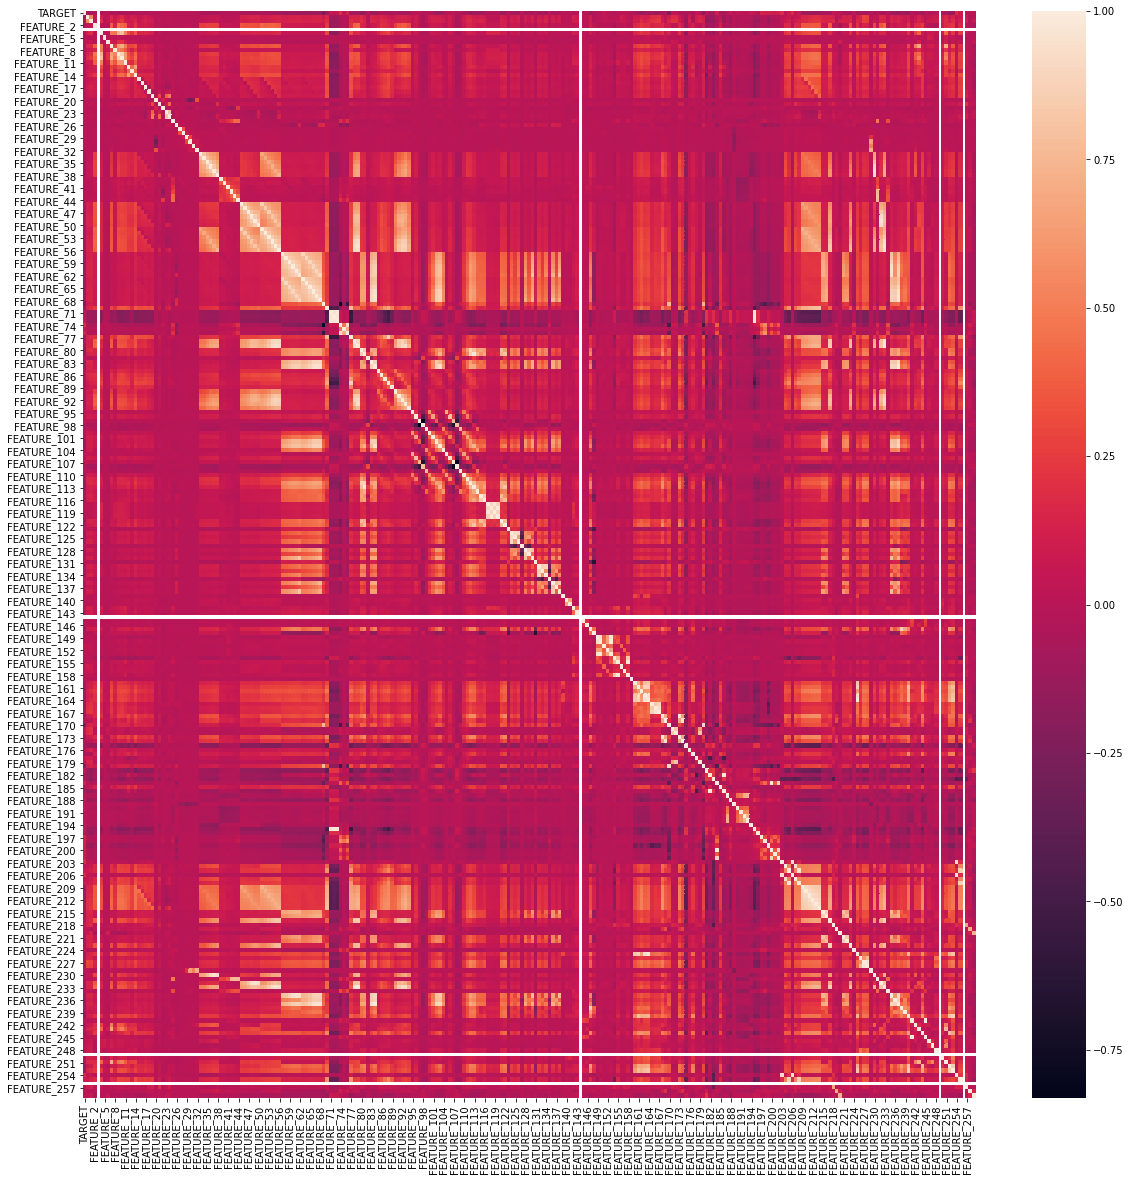

In [12]:
cor = df.corr()
plt.figure(figsize= (20, 20))
sns.heatmap(df.corr())

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:>

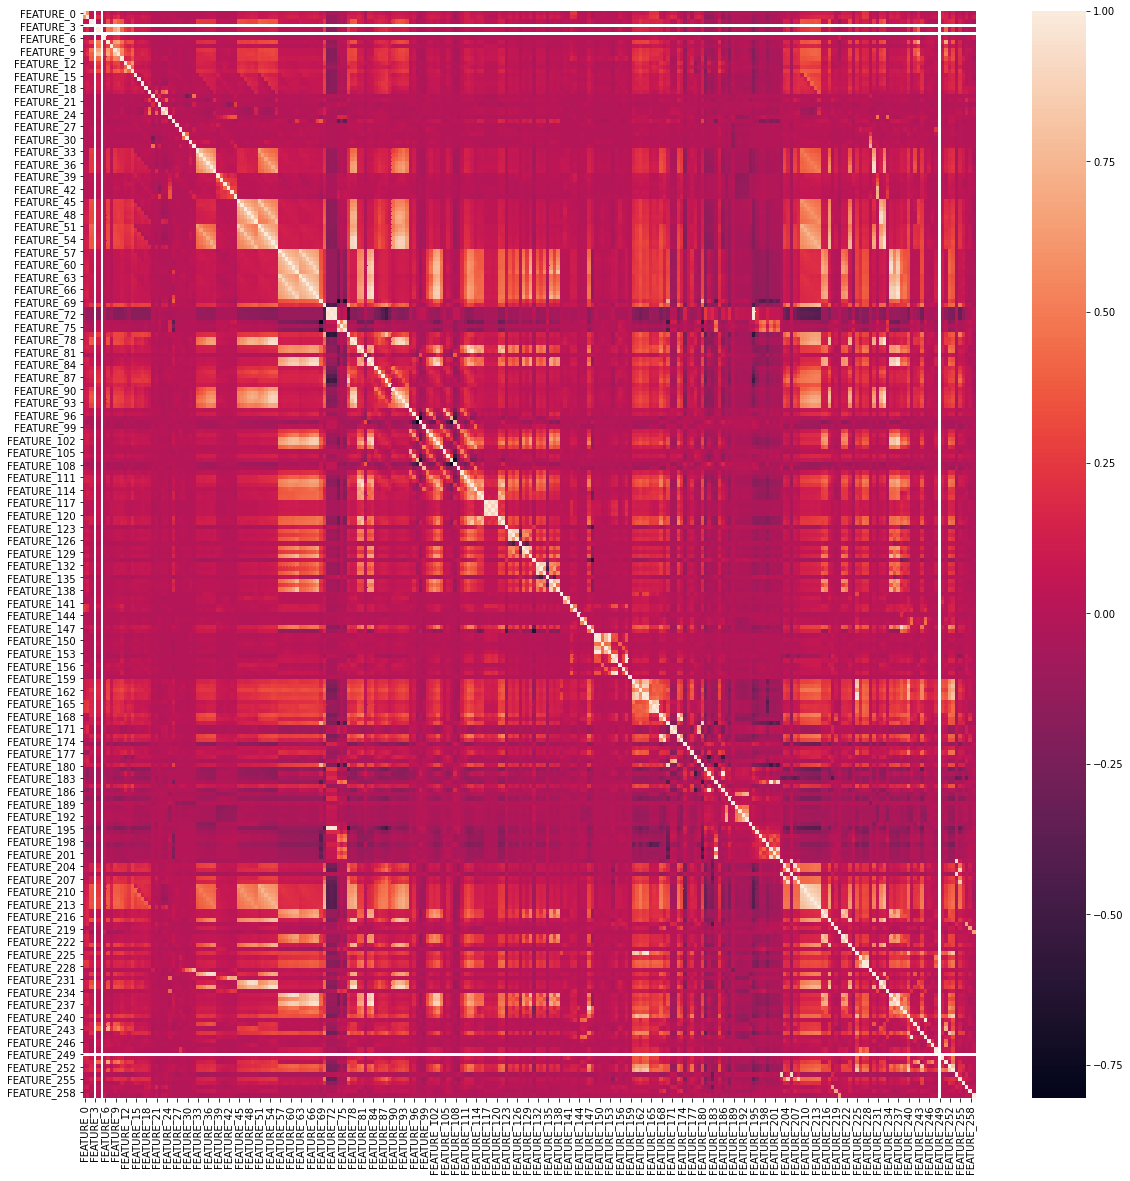

In [13]:
plt.figure(figsize= (20, 20))
sns.heatmap(dft.corr())

In [14]:
threshold = 0.15 
a=abs(cor['TARGET'])
result = a[a>0.15]
result

TARGET         1.000000
FEATURE_69     0.253393
FEATURE_74     0.183590
FEATURE_80     0.161007
FEATURE_170    0.234392
FEATURE_180    0.210143
FEATURE_203    0.181191
FEATURE_206    0.175827
FEATURE_254    0.178763
Name: TARGET, dtype: float64

In [15]:
df.TARGET.value_counts()

0    17372
1     5650
2     1499
Name: TARGET, dtype: int64

In [16]:
df.TARGET.value_counts(normalize=True)

0    0.708454
1    0.230415
2    0.061131
Name: TARGET, dtype: float64

In [5]:
#df = df.drop(['FEATURE_8', 'FEATURE_71', 'FEATURE_72', 'FEATURE_73', 'FEATURE_149', 
#            'FEATURE_150', 'FEATURE_151', 'FEATURE_152', 'FEATURE_153', 'FEATURE_162', 'FEATURE_187', 'FEATURE_188',
#            'FEATURE_189', 'FEATURE_190', 'FEATURE_191', 'FEATURE_192', 'FEATURE_193', 'FEATURE_194',
#            'FEATURE_195','FEATURE_196'], axis=1)

In [6]:
#dft = dft.drop(['FEATURE_8', 'FEATURE_71', 'FEATURE_72', 'FEATURE_73', 'FEATURE_149', 
#            'FEATURE_150', 'FEATURE_151', 'FEATURE_152', 'FEATURE_153', 'FEATURE_162', 'FEATURE_187', 'FEATURE_188',
#            'FEATURE_189', 'FEATURE_190', 'FEATURE_191', 'FEATURE_192', 'FEATURE_193', 'FEATURE_194',
#            'FEATURE_195','FEATURE_196'], axis=1)

In [14]:
#df = df.drop(['FEATURE_3', 'FEATURE_144', 'FEATURE_249', 'FEATURE_256', 'FEATURE_5'], axis=1)

In [15]:
#dft = dft.drop(['FEATURE_3', 'FEATURE_144', 'FEATURE_249', 'FEATURE_256', 'FEATURE_5'], axis=1)

In [17]:
df = df.drop(['FEATURE_3', 'FEATURE_144', 'FEATURE_249', 'FEATURE_256', 'FEATURE_5','FEATURE_7',
    'FEATURE_2', 'FEATURE_4', 'FEATURE_6', 'FEATURE_11', 'FEATURE_15', 
            'FEATURE_16', 'FEATURE_17', 'FEATURE_18', 'FEATURE_19', 'FEATURE_123', 
              'FEATURE_131', 'FEATURE_140',
            'FEATURE_159', 'FEATURE_204', 'FEATURE_205', 'FEATURE_207', 'FEATURE_208',
              'FEATURE_254','FEATURE_10','FEATURE_24','FEATURE_34','FEATURE_35','FEATURE_36',
              'FEATURE_37','FEATURE_38','FEATURE_45','FEATURE_46','FEATURE_47','FEATURE_48',
              'FEATURE_49','FEATURE_50','FEATURE_51','FEATURE_52','FEATURE_53','FEATURE_54','FEATURE_55',
              'FEATURE_56','FEATURE_57','FEATURE_58','FEATURE_59','FEATURE_60','FEATURE_61','FEATURE_62',
              'FEATURE_63','FEATURE_64','FEATURE_65','FEATURE_66','FEATURE_67','FEATURE_68','FEATURE_72',
              'FEATURE_73','FEATURE_116','FEATURE_117','FEATURE_118','FEATURE_119','FEATURE_120','FEATURE_121',
              'FEATURE_209','FEATURE_210','FEATURE_211','FEATURE_212','FEATURE_213','FEATURE_255'], axis=1)

In [18]:
dft = dft.drop(['FEATURE_3', 'FEATURE_144', 'FEATURE_249', 'FEATURE_256', 'FEATURE_5','FEATURE_7',
    'FEATURE_2', 'FEATURE_4', 'FEATURE_6', 'FEATURE_11', 'FEATURE_15', 
            'FEATURE_16', 'FEATURE_17', 'FEATURE_18', 'FEATURE_19', 'FEATURE_123', 
              'FEATURE_131', 'FEATURE_140',
            'FEATURE_159', 'FEATURE_204', 'FEATURE_205', 'FEATURE_207', 'FEATURE_208',
              'FEATURE_254','FEATURE_10','FEATURE_24','FEATURE_34','FEATURE_35','FEATURE_36',
              'FEATURE_37','FEATURE_38','FEATURE_45','FEATURE_46','FEATURE_47','FEATURE_48',
              'FEATURE_49','FEATURE_50','FEATURE_51','FEATURE_52','FEATURE_53','FEATURE_54','FEATURE_55',
              'FEATURE_56','FEATURE_57','FEATURE_58','FEATURE_59','FEATURE_60','FEATURE_61','FEATURE_62',
              'FEATURE_63','FEATURE_64','FEATURE_65','FEATURE_66','FEATURE_67','FEATURE_68','FEATURE_72',
              'FEATURE_73','FEATURE_116','FEATURE_117','FEATURE_118','FEATURE_119','FEATURE_120','FEATURE_121',
              'FEATURE_209','FEATURE_210','FEATURE_211','FEATURE_212','FEATURE_213','FEATURE_255'], axis=1)

In [19]:
df['f1']=df.iloc[:,17:21].sum(1)
df['f2']=df.iloc[:,47:58].sum(1)
df['f3']=df.iloc[:,59:70].sum(1)
df['f4']=df.iloc[:,118:123].sum(1)
df['f5']=df.iloc[:,211:215].sum(1)

In [20]:
dft['f1']=dft.iloc[:,16:20].sum(1)
dft['f2']=dft.iloc[:,46:57].sum(1)
dft['f3']=dft.iloc[:,58:69].sum(1)
dft['f4']=dft.iloc[:,117:122].sum(1)
dft['f5']=dft.iloc[:,210:214].sum(1)

In [21]:
y_train = df['TARGET']
X_train = df.drop(['TARGET','ID'], axis=1)
X_test = dft.drop(['ID'], axis=1)
y_test = dft['ID']

<AxesSubplot:>

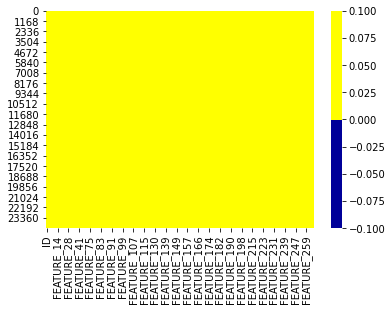

In [23]:
cols = df.columns[:261]
colours = ['#000099', '#ffff00']
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [26]:
df = df.fillna(df.mean())
dft = dft.fillna(dft.mean())

In [27]:
#Cтандартизация
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() 

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [27]:
#Метод главных компонент
#from sklearn.decomposition import PCA

#pca = PCA(n_components = 100)

#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)

#explained_variance = pca.explained_variance_ratio_
#explained_variance

array([0.15080466, 0.06276656, 0.03469744, 0.0301274 , 0.02398556,
       0.02260199, 0.02190093, 0.02069242, 0.01889102, 0.01793873,
       0.01569124, 0.01431046, 0.01404345, 0.01368635, 0.01286905,
       0.01242323, 0.01214315, 0.01164168, 0.01105271, 0.01088573,
       0.01059893, 0.01040562, 0.00997487, 0.00994473, 0.00948519,
       0.00936896, 0.00865126, 0.00850394, 0.00819568, 0.00797768,
       0.00774333, 0.00759493, 0.00735898, 0.00708057, 0.00699734,
       0.00670128, 0.00657299, 0.00640837, 0.00629115, 0.00611799,
       0.00605854, 0.00595739, 0.00577542, 0.00560765, 0.00558138,
       0.00545028, 0.00540655, 0.00532065, 0.00530689, 0.00520374,
       0.00513016, 0.00509852, 0.00503714, 0.00495068, 0.00493347,
       0.00474892, 0.00463089, 0.00458252, 0.00453767, 0.00450867,
       0.00441518, 0.0043359 , 0.00422339, 0.0041816 , 0.00416124,
       0.00408021, 0.00398116, 0.00394788, 0.00389275, 0.00387896,
       0.00383013, 0.00376626, 0.00364233, 0.00356407, 0.00354

## Строим модели

In [13]:
from sklearn.tree import DecisionTreeClassifier
modelDTC = DecisionTreeClassifier(
    #criterion = 'gini',
    #max_depth = 5,
    #min_sample_split = 5,
    #class_weight = 'balanced'
)

In [33]:
modelDTC.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [34]:
preds_clf = modelDTC.predict(X_test)

In [35]:
preds_clf

array([1, 0, 1, ..., 0, 1, 0])

In [14]:
from sklearn.linear_model import LogisticRegression
modelLR = LogisticRegression(
    #random_state=42,
    # метод для поиска решения. Для небольших датасетов лучше подходит liblinear, sag и saga -- для больших.
    # Варианты: newton-cg, lbfgs, liblinear, sag, saga
    #solver='sag',
    # норма для регуляризации. Варианты: l2, l1.
    penalty='l2',
    # параметр регуляризации. Чем меньше, тем сильнее регуляризация. Положительный.
    #C=1,
    # параметр для остановки поиска решения.
    #tol=1e-4,
    # Так как распознается 2 класса.
    #multi_class='ovr',
    class_weight='balanced'
    )

In [10]:
modelLR.fit(X_train, y_train)

/Users/antonskarednov/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
predsLR = modelLR.predict(X_test)

In [15]:
from sklearn.ensemble import RandomForestClassifier
modelRFC = RandomForestClassifier(
    #class_weight = 'balanced'
)

In [28]:
%%time
modelRFC.fit(X_train, y_train)

CPU times: user 46.9 s, sys: 390 ms, total: 47.3 s
Wall time: 49.2 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
predsRFC = modelRFC.predict(X_test)

In [16]:
from xgboost import XGBClassifier
modelXGBC = XGBClassifier(
    #class_weight = 'balanced'
)

In [24]:
%%time
modelXGBC.fit(X_train, y_train)

CPU times: user 3min 41s, sys: 1.2 s, total: 3min 42s
Wall time: 3min 45s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [25]:
predsXGBC = modelXGBC.predict(X_test)

In [26]:
predsXGBC

array([0, 0, 0, ..., 0, 0, 0])

Cтекинг

In [17]:
from sklearn.ensemble import  StackingClassifier

In [18]:
base_learners = [
                 ('rf_1', RandomForestClassifier(
                     class_weight = 'balanced')),
                 #('rf_3', DecisionTreeClassifier(
                  #  class_weight = 'balanced')),
                 ('rf_4', LogisticRegression(
                     class_weight = 'balanced',)),
                ]

In [19]:
f_estimator=LogisticRegression(class_weight = 'balanced')

In [20]:
clf = StackingClassifier(estimators=base_learners, final_estimator=f_estimator, cv=10)

In [28]:
%%time
clf.fit(X_train, y_train)

/Users/antonskarednov/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/antonskarednov/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

CPU times: user 6min 38s, sys: 3.49 s, total: 6min 42s
Wall time: 6min 44s


StackingClassifier(cv=10,
                   estimators=[('rf_1',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight='balanced',
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                               

In [29]:
predsST = clf.predict(X_test)

###### 

In [25]:
#from sklearn.metrics import f1_score
#f1_score(y_train, predsST, average='macro')

In [23]:
y_test = pd.DataFrame(y_test)

In [24]:
y_test

,ID
0,0749d313171551f
1,ddb093edbbbe1ef
2,cef8538a6054069
3,780e061918507d4
4,bb7e0f377a5bb14
...,...
9479,d3e71867542751c
9480,504a3c8d88ae560
9481,f9b4c14c4a3ad4c
9482,4f5dfbe10a878b2


In [28]:
y_test['Predicted'] = preds_clf

In [15]:
y_test['Predicted'] = predsLR

In [30]:
y_test['Predicted'] = predsRFC

In [29]:
y_test['Predicted'] = predsXGBC

In [30]:
y_test['Predicted'] = predsST

In [ ]:
y_test

In [70]:
y_test.to_csv('submST15.csv', index=False)

In [38]:
y_test.Predicted.value_counts()
#53

1    3818
0    3673
2    1993
Name: Predicted, dtype: int64